### Задание 1

In [1]:
import pandas as pd

Читаем данные из таблицы

In [52]:
file_path = r"C:\Users\dolph\Documents\test_task1_data.xlsx"
data_model1 = pd.read_excel(file_path, sheet_name="data_Model1")
data_model2 = pd.read_excel(file_path, sheet_name="data_Model2")
emotion_labels = pd.read_excel(file_path, sheet_name="emotion_labels")

Фунция, которая среди выданных моделью вероятностей для каждого кадра определяет наиболее вероятную эмоцию

In [54]:
def predict_emotion(row):
    emotions = ["neutral", "happy", "sad", "surprise", "fear", "disgust", "anger"]
    probabilities = row[emotions].astype(float)
    return probabilities.idxmax()

Применим функцию к датафрейму и создадим новый столбец с наиболее вероятной эмоцией

In [55]:
data_model1["predicted_emotion"] = data_model1.apply(predict_emotion, axis=1)
data_model2["predicted_emotion"] = data_model2.apply(predict_emotion, axis=1)

Эта функция обрабатывает эмоции для всех кадров видео и выбирает из них наиболее частотную (так как в ответе содержится по одной эмоции для каждого видео)

In [56]:
def most_frequent_emotion(predictions):
    return predictions.mode()[0]

In [57]:
data_model1_final = data_model1.groupby("file_name")["predicted_emotion"].agg(most_frequent_emotion).reset_index()
data_model2_final = data_model2.groupby("file_name")["predicted_emotion"].agg(most_frequent_emotion).reset_index()

Объединяем датафреймы с предсказаниями и ответами

In [59]:
data_model1_final = data_model1_final.merge(emotion_labels, on="file_name")
data_model2_final = data_model2_final.merge(emotion_labels, on="file_name")

Функция, рассчитывающая как общее качество предсказаний, так и предсказания по эмоциям

In [60]:
def calculate_accuracy(df):
    df["correct"] = df["predicted_emotion"] == df["label"]
    overall_accuracy = df["correct"].mean()
    accuracy_by_emotion = df.groupby("label")["correct"].mean()
    return overall_accuracy, accuracy_by_emotion

In [61]:
accuracy_model1, emotion_accuracy_model1 = calculate_accuracy(data_model1_final)
accuracy_model2, emotion_accuracy_model2 = calculate_accuracy(data_model2_final)

In [62]:
winner = "Model 1" if accuracy_model1 > accuracy_model2 else "Model 2"

In [63]:
print("Model 1 Overall Accuracy:", accuracy_model1)
print("Model 1 Accuracy by Emotion:")
print(emotion_accuracy_model1)
print("\nModel 2 Overall Accuracy:", accuracy_model2)
print("Model 2 Accuracy by Emotion:")
print(emotion_accuracy_model2)
print("\nWinner:", winner)

Model 1 Overall Accuracy: 0.9166666666666666
Model 1 Accuracy by Emotion:
label
anger       0.750000
disgust     1.000000
fear        0.833333
happy       1.000000
neutral     1.000000
sad         0.833333
surprise    1.000000
Name: correct, dtype: float64

Model 2 Overall Accuracy: 0.8571428571428571
Model 2 Accuracy by Emotion:
label
anger       0.750000
disgust     0.833333
fear        0.833333
happy       1.000000
neutral     0.583333
sad         1.000000
surprise    1.000000
Name: correct, dtype: float64

Winner: Model 1


Первая модель идеально определяет эмоции отвращения, счастья, нейтральную эмоцию, удивление, также ее качество по всем эмоциям выше, чем у второй модели. Вторая модель идеально справляется с определением счастья, грусти, удивления. Построим графики для лучшего понимания результатов:

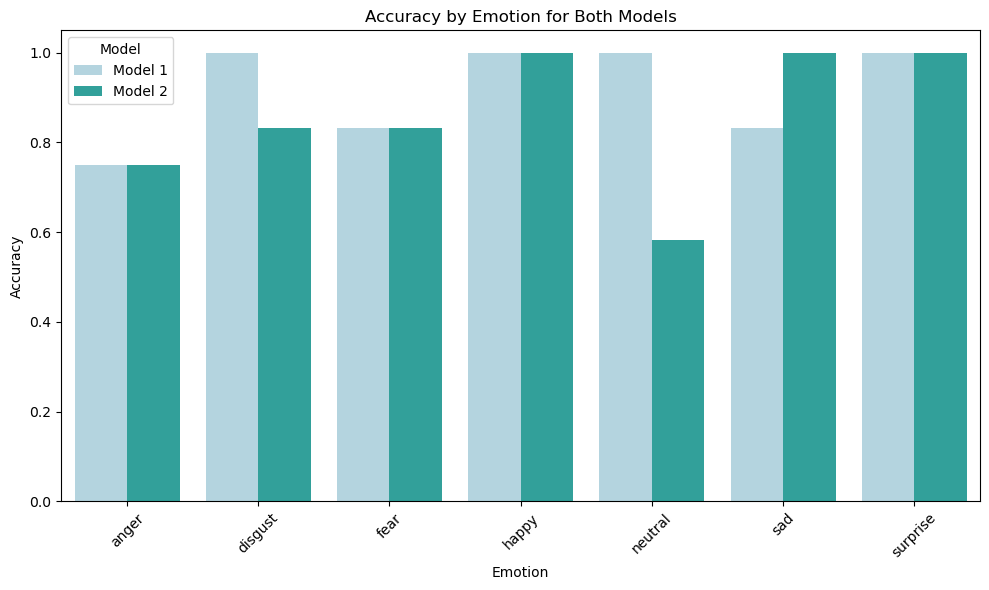

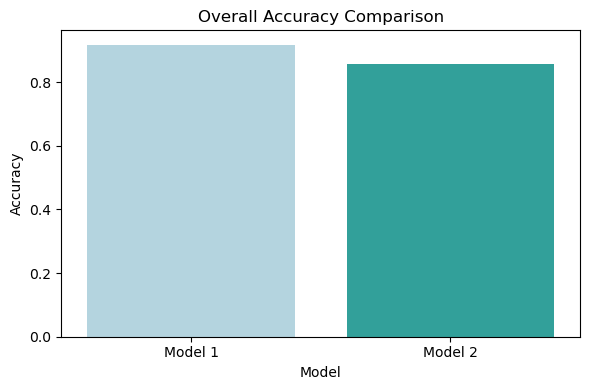

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_accuracy_by_emotion(accuracy_model1, accuracy_model2):
    accuracy_df = pd.DataFrame({
        "Emotion": accuracy_model1.index,
        "Model 1": accuracy_model1.values,
        "Model 2": accuracy_model2.values
    })
    
    accuracy_df_melted = accuracy_df.melt(id_vars="Emotion", value_vars=["Model 1", "Model 2"],
                                          var_name="Model", value_name="Accuracy")
    
    colors = ["#add8e6", "#20b2aa"]
    
    # Создание графика
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Emotion", y="Accuracy", hue="Model", data=accuracy_df_melted, palette=colors)
    plt.title("Accuracy by Emotion for Both Models")
    plt.xlabel("Emotion")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_overall_accuracy(accuracy_model1, accuracy_model2):
    accuracy_df = pd.DataFrame({
        "Model": ["Model 1", "Model 2"],
        "Accuracy": [accuracy_model1, accuracy_model2]
    })
    
    colors = ["#add8e6", "#20b2aa"]  
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x="Model", y="Accuracy", data=accuracy_df, palette=colors)
    plt.title("Overall Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

plot_accuracy_by_emotion(emotion_accuracy_model1, emotion_accuracy_model2)

plot_overall_accuracy(accuracy_model1, accuracy_model2)

Видно, что несколько эмоций модели определяют одинаково хорошо (гнев, страх, счастье, удивление). Нейтральную эмоцию и отвращение лучше определяет первая модель, однако вторая модель лучше справляется с определением грусти. В целом, общее качество и лучшее распознавание большего количества эмоций имеет первая модель. Однако, вторую модель можно использовать для задачи определения грусти.

### Задание 2

Читаем данные из файлов

In [71]:
data_jockey = pd.read_csv(r'C:\Users\dolph\Documents\test_task2_data_jockey.csv', delimiter=';')
data_carte_noire = pd.read_csv(r'C:\Users\dolph\Documents\test_task2_data_carte_noire.csv', delimiter=';')

Переводим данные из столбцов вероятностей в нужный формат float

In [72]:
for df in [data_jockey, data_carte_noire]:
    df[cols_to_convert] = df[cols_to_convert].replace(',', '.', regex=True).astype(float)

Функция для расчета эмоциональных сдвигов. Сначала делим данные на baseline (включающий baseline и eyetracker как время калибровки в течение 34 секунд) и content (время показа роликов). Далее вычисляем медианы эмоций по baseline для каждого респондента. Затем объединяем медианные значения с контентными данными и рассчитываем сдвиги для каждой эмоции. Для каждого респондента было решено взять среднее значение сдвига для каждой эмоции на основе эмоций, выделенных в каждую секунду content. На выходе получается датафрейм с количеством строк равному количеству респондентов и со средними значениями эмоциональных сдвигов по каждой эмоции.

In [73]:
def calculate_emotional_shifts(df):
    baseline_data = df[df['sec_type'].isin(['baseline', 'eyetracker'])]
    content_data = df[df['sec_type'] == 'content']

    baseline_medians = baseline_data.groupby('id')[cols_to_convert].median().rename(columns=lambda x: f"baseline_{x}")

    content_data = content_data.merge(baseline_medians, on='id', how='left')

    for col in cols_to_convert:
        content_data[f"shift_{col}"] = content_data[col] - content_data[f"baseline_{col}"]

    shift_columns = [f"shift_{col}" for col in cols_to_convert]
    avg_shifts = content_data.groupby('id')[shift_columns].mean()

    return avg_shifts.reset_index()

Применяем функции и создаем новые датафреймы

In [74]:
shifts_jockey = calculate_emotional_shifts(data_jockey)
shifts_carte_noire = calculate_emotional_shifts(data_carte_noire)

Аггрегируем эмоциональные отклики для каждого ролика (вычисляем средние значения по эмоциям)

In [76]:
def aggregate_emotional_response(df, cols):
    return df[cols].mean()

shift_columns = [f"shift_{col}" for col in cols_to_convert]

response_jockey = aggregate_emotional_response(shifts_jockey, shift_columns)
response_carte_noire = aggregate_emotional_response(shifts_carte_noire, shift_columns)

Выведем получившиеся значения сдвигов

In [77]:
response_jockey

shift_anger      -0.006533
shift_disgust     0.007590
shift_fear        0.001659
shift_happy       0.039336
shift_neutral    -0.018868
shift_sad        -0.010306
shift_surprise    0.006591
dtype: float64

In [78]:
response_carte_noire

shift_anger      -0.002988
shift_disgust     0.003549
shift_fear        0.002847
shift_happy       0.001075
shift_neutral    -0.061122
shift_sad         0.012150
shift_surprise    0.002212
dtype: float64

Построим графики для лучшей визуализации текстовых результатов

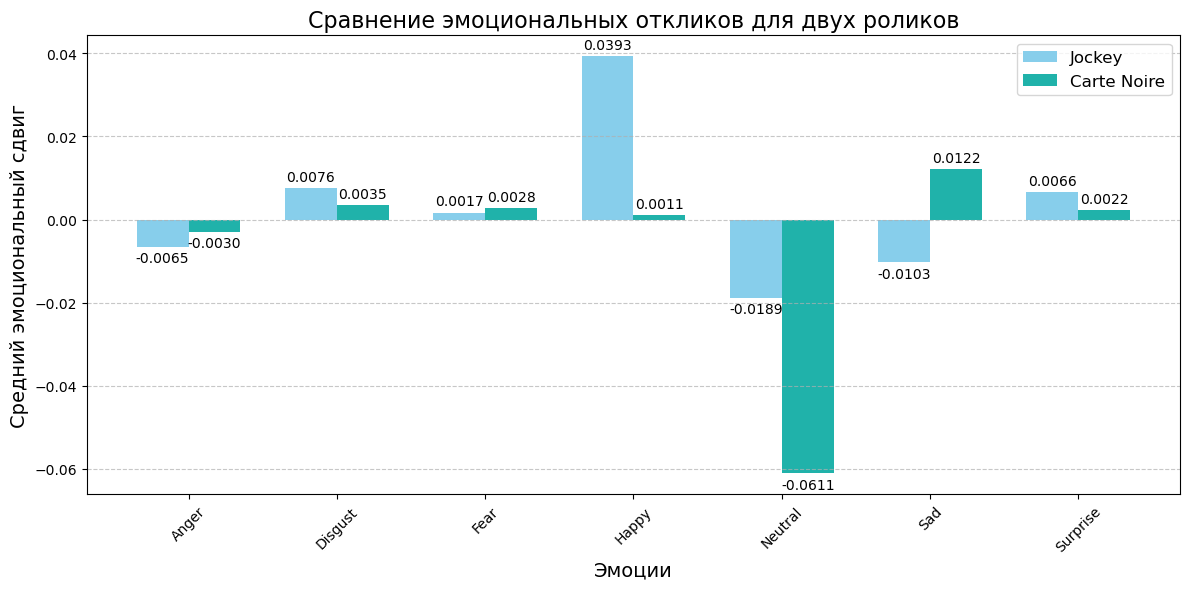

In [79]:
import numpy as np

shift_columns = [f"shift_{col}" for col in cols_to_convert]
responses = pd.DataFrame({
    'Emotions': shift_columns,
    'Jockey': response_jockey.values,
    'Carte Noire': response_carte_noire.values
})

x = np.arange(len(shift_columns))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, responses['Jockey'], width, label='Jockey', color='skyblue')
bars2 = ax.bar(x + width/2, responses['Carte Noire'], width, label='Carte Noire', color='lightseagreen')

for bars in [bars1, bars2]:
    ax.bar_label(bars, fmt='%.4f', padding=3, fontsize=10)

ax.set_title('Сравнение эмоциональных откликов для двух роликов', fontsize=16)
ax.set_ylabel('Средний эмоциональный сдвиг', fontsize=14)
ax.set_xlabel('Эмоции', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([col.replace('shift_', '').capitalize() for col in shift_columns], rotation=45)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

- Положительные значения эмоционального сдвига означают, что эмоция стала сильнее, чем во время калибровки 
- Отрицательные значения означают, что эмоция стала слабее по сравнению с baseline
- Эмоция neutral для обоих роликов отрицательная, это говорит о том, что они вызвали больше вовлечённости в другие эмоции (не оставили зрителей равнодушными)
- Ролик с рекламой jockey вызвал у респондентов выраженную эмоцию счастья
- Ролик с рекламой jockey вызвал у респондентов более выраженные эмоции отвращения и удивления по сравнению с роликом carte noire
- Ролик с рекламой carte noire вызвал у респондентов намного более выраженную эмоцию грусти, чем ролик с рекламой jockey
- Ролик с рекламой carte noire вызвал у респондентов немного более выраженную эмоцию страха, чем ролик с рекламой jockey

Таким образом, реклама кофе jockey, судя по эмоциональному отклику респондентов, вызывает больше положительных эмоций (счастье и удивление), что делает ее более выигрышной.

Теперь проведем небольшой статистический анализ, позволяющий оценить значимость полученных результатов. Мы исходим из того, что 2 ролика оценивали 2 разные группы респондентов (id испытуемых не совпадают в двух таблицах), поэтому выборки независимые. Для этого мы проделаем следующие шаги:
1. Для каждой эмоции проверим, соответствуют ли данные нормальному распределению с помощью критерия Шапиро–Уилка. Если  p > 0.05, распределение считается близким к нормальному
2. Если данные нормально распределены: используем t-тест
3. Если данные распределены не нормально: используем U-тест Манна–Уитни
4. Для каждой эмоции посчитаем статистику и p-значение, чтобы определить, есть ли различия между роликами. Если p < 0.05, различия значимы, эмоции для двух роликов значимо отличаются. Если p > 0.05, эмоциональный отклик не различается значимо с точки зрения статистики

In [80]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

def compare_emotions(df1, df2, emotions):
    results = []
    for emotion in emotions:
        data1 = df1[f'shift_{emotion}']
        data2 = df2[f'shift_{emotion}']
        
        stat1, p1 = shapiro(data1)
        stat2, p2 = shapiro(data2)
        is_normal = (p1 > 0.05) and (p2 > 0.05)

        if is_normal:
            stat, p_value = ttest_ind(data1, data2, equal_var=False)  # t-тест
            test_type = 't-test'
        else:
            stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')  # U-тест
            test_type = 'Mann-Whitney U-test'

        results.append({
            'Emotion': emotion,
            'Test': test_type,
            'Statistic': stat,
            'p-value': p_value,
            'Significant': p_value < 0.05
        })
    
    return pd.DataFrame(results)

emotions = [col.replace('shift_', '') for col in shift_columns]
results = compare_emotions(shifts_jockey, shifts_carte_noire, emotions)

print(results)

    Emotion                 Test  Statistic       p-value  Significant
0     anger  Mann-Whitney U-test    10295.0  6.230251e-01        False
1   disgust  Mann-Whitney U-test    11365.0  3.218019e-01        False
2      fear  Mann-Whitney U-test    11694.0  1.479054e-01        False
3     happy  Mann-Whitney U-test    15482.0  2.089881e-11         True
4   neutral  Mann-Whitney U-test    13621.0  3.804454e-05         True
5       sad  Mann-Whitney U-test     9322.0  6.565402e-02        False
6  surprise  Mann-Whitney U-test    12090.0  4.592485e-02         True


Для счастья, нейтральной эмоции и удивления различия между двумя роликами значимы (p-value < 0.05).
Для гнева, отвращения, страха, грусти различия не значимы (p-value > 0.05).

- Таким образом, мы подтвердили количественные наблюдения с точки зрения статистики и можем утверждать, что ролик jockey вызывает другие эмоции по сравнению с роликом carte noir (в частности, радости и удивления). 
- Ролик carte noire согласно данным графиков вызывал более выраженную эмоцию грусти по сравнению с роликом jockey, однако эти результаты не являются статистически значимыми, следовательно, мы не можем утверждать, что ролик carte noire вызывает выраженную эмоцию грусти. 
- Интересно наблюдение более отрицательного эмоционального сдвига нейтральной эмоции при просмотра ролика carte noire. При этом, никаких сильных эмоций он тоже не вызвал, но снижение нейтральности говорит о том, что эмоция изменилась по отношению к нейтральной. Предполагаю, что здесь могла быть вызвана другая эмоция, например, ролик показался респондентам неинтересным, что изменило нейтральную эмоцию в сторону эмоции отстраненности. Однако это одно из предположений, нужно интерпретировать этот момент более подробно с опорой на предыдущие исследования.
- Различия между роликами в отношении эмоций  гнева, отвращения, страха не отличаются значимо, мы не можем утверждать, что эти ролики вызывают разную степень выраженности этих эмоций.
 

Итого: согласно графикам и статистическим тестам, ролик jockey является более выигрышным, так как вызывает выраженные положительные эмоции по сравнению с роликом carte noire